In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add parent directory to sys.path for module imports
import os
import sys
sys.path.append(os.path.abspath(".."))

from sklearn.model_selection import train_test_split
from src.feature_engineering import load_vectorizer
import pickle

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

## **Load Clean Dataset**

In [6]:
df = pd.read_csv("../data/processed/cleaned_spam_dataset.csv", encoding='latin-1')
df.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [7]:
# Define features and labels
X = df["cleaned_message"]
y = df["label"]

In [8]:
# split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# load vectorizer from disk
vectorizer = load_vectorizer("../models/tfidf_vectorizer.pkl")

In [10]:
# transform train and test data
X_test_tfidf = vectorizer.transform(X_test)

## **Naive Bayes Model**

In [11]:
# load the trained Naive Bayes model to make predictions
with open("../models/naive_bayes.pkl", "rb") as f:
    nb_model = pickle.load(f)

In [12]:
nb_pred = nb_model.predict(X_test_tfidf)

**Confusion Matrix for Naive Bayes**

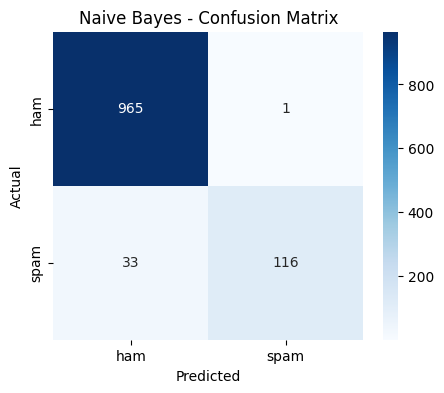

In [13]:
nb_cm = confusion_matrix(y_test, nb_pred, labels=["ham", "spam"])

plt.figure(figsize=(5,4))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham", "spam"],
            yticklabels=["ham", "spam"])
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **Naive Bayes Evaluation Summary**

- Naive Bayes performs well on spam detection with strong precision.
- It correctly identifies most spam messages but misses a few (lower recall).
- It also generates some false positives where normal (ham) messages are marked as spam.
- This model is fast and lightweight, making it an excellent baseline, but not the best final model.


## **Main Model Supprt Vector Machine Evaluation**

In [ ]:
# load the trained support vector machine (SVM) model to make predictions

with open("../models/svm_model.pkl", "rb") as f:
    svm_model = pickle.load(f)

In [18]:
# make predictions using the trained SVM model
svm_pred = svm_model.predict(X_test_tfidf)

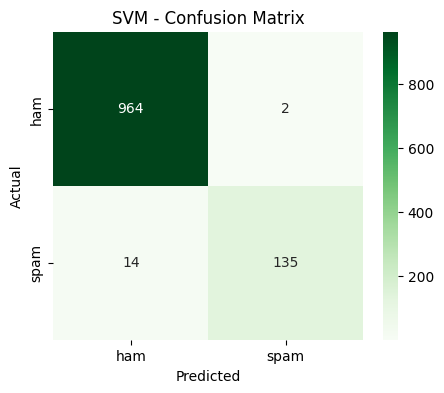

In [19]:
# plot confusion matrix for SVM
svm_cm = confusion_matrix(y_test, svm_pred, labels=["ham", "spam"])

plt.figure(figsize=(5,4))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham", "spam"],
            yticklabels=["ham", "spam"])
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
print("SVM - Classification Report")
print(classification_report(y_test, svm_pred))

SVM - Classification Report
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



### **SVM Evaluation Summary**

- SVM outperforms Naive Bayes in every key metric.
- It catches more spam messages (higher recall).
- It makes fewer mistakes labelling normal messages as spam (higher precision).
- Overall F1 score is higher, making SVM the strongest model.
- This model should be selected as the final production model.

## **Compute all metrics again**

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Model": ["Naive Bayes", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, svm_pred)
    ],
    "Precision (Spam)": [
        precision_score(y_test, nb_pred, pos_label="spam"),
        precision_score(y_test, svm_pred, pos_label="spam")
    ],
    "Recall (Spam)": [
        recall_score(y_test, nb_pred, pos_label="spam"),
        recall_score(y_test, svm_pred, pos_label="spam")
    ],
    "F1 Score (Spam)": [
        f1_score(y_test, nb_pred, pos_label="spam"),
        f1_score(y_test, svm_pred, pos_label="spam")
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Accuracy,Precision (Spam),Recall (Spam),F1 Score (Spam)
0,Naive Bayes,0.969507,0.991453,0.778523,0.872180
1,SVM,0.985650,0.985401,0.906040,0.944056


### **Bar plot for visual comparisom**

<Figure size 1000x600 with 0 Axes>

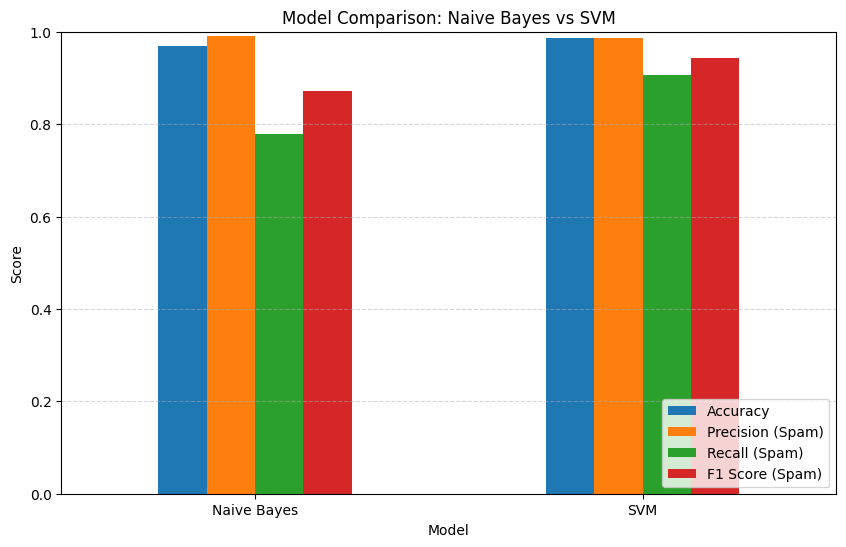

In [26]:
metrics_df_plot = metrics_df.set_index("Model")

plt.figure(figsize=(10,6))
metrics_df_plot.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Naive Bayes vs SVM")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### Model Comparison Insights

- SVM consistently outperforms Naive Bayes across all metrics.
- SVM has higher precision, meaning fewer false spam alerts.
- SVM has higher recall, meaning it detects more spam messages.
- The F1 score for SVM is higher, making it the more balanced and reliable model.
- Final model chosen for deployment: SVM.


## **The Precision-Recall Curve for both models (Naive Bayes and SVM).**

### **Precision-Recall for Naive Bayes**

In [33]:
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]  # probability spam=1
# convert labels to numeric (0 = ham, 1 = spam)
nb_precision, nb_recall, nb_thresholds = precision_recall_curve(y_test.map({'ham':0, 'spam':1}), nb_probs)

### **Precision-Recall**

In [34]:
svm_scores = svm_model.decision_function(X_test_tfidf)
svm_precision, svm_recall, svm_thresholds = precision_recall_curve(y_test.map({'ham':0, 'spam':1}), svm_scores)

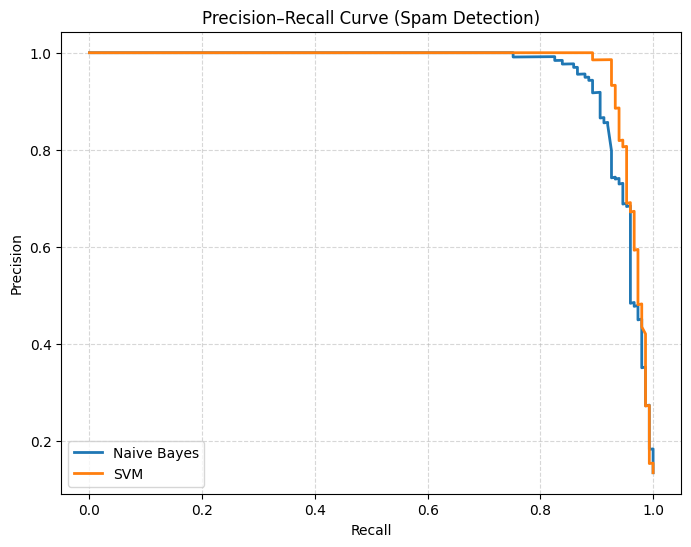

In [42]:
# Plot Precision-Recall curves for both models
plt.figure(figsize=(8,6))
plt.plot(nb_recall, nb_precision, label="Naive Bayes", linewidth=2)
plt.plot(svm_recall, svm_precision, label="SVM", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Spam Detection)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("../images/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()



### Precision-Recall Curve Summary

- The SVM model achieves a better precision–recall trade-off compared to Naive Bayes.
- SVM maintains higher precision across a wider range of recall values.
- Naive Bayes drops in precision much earlier, meaning it is more likely to produce false positives.
- For spam detection, where recall (catching spam) is critical, SVM is the superior model.

### **ROC Curve For Both Models**

In [36]:
from sklearn.metrics import roc_curve, auc

In [37]:
# convert labels to binary
y_test_binary = y_test.map({'ham':0, 'spam':1})

In [39]:
# model score ROC for Naive Bayes
# Naive Bayes use predict_proba
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test_binary, nb_probs)
nb_auc = auc(nb_fpr, nb_tpr)

In [40]:
# model score ROC for SVM
# SVM use decision_function
svm_scores = svm_model.decision_function(X_test_tfidf)
svm_fpr, svm_tpr, _ = roc_curve(y_test_binary, svm_scores)
svm_auc = auc(svm_fpr, svm_tpr)

### **Plot BOTH ROC curves for the two model**

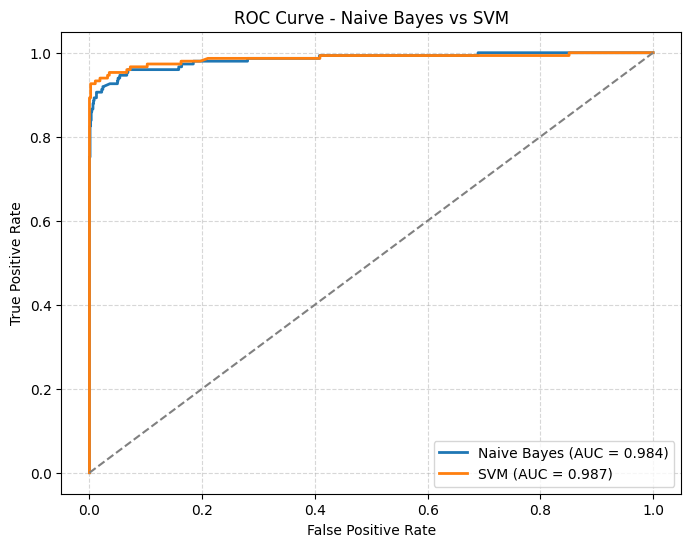

In [41]:
plt.figure(figsize=(8,6))

plt.plot(nb_fpr, nb_tpr, label=f"Naive Bayes (AUC = {nb_auc:.3f})", linewidth=2)
plt.plot(svm_fpr, svm_tpr, label=f"SVM (AUC = {svm_auc:.3f})", linewidth=2)

# Diagonal baseline
plt.plot([0,1], [0,1], linestyle="--", color="grey")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes vs SVM")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### **ROC Curve Summary**

- The SVM model achieves a higher AUC score, indicating stronger overall classification ability.
- The Naive Bayes curve performs well but drops earlier, showing its limitations.
- SVM maintains a better balance between sensitivity (TPR) and false positive rate.
- This confirms SVM as the best-performing model for deployment.